<a href="https://colab.research.google.com/github/jnmaloof/DeepLearning_JulinMaloof/blob/main/Intox_predictions_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages("keras")
install.packages("R.utils") 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’




In [3]:
library(R.utils)
library(tidyverse)
library(keras)
library(tensorflow)
tf$config$experimental$list_physical_devices()

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.11.0 (2021-09-26 08:30:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────

[[1]]
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

[[2]]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
if(!file.exists("data.zip")) {
  download.file(url="http://archive.ics.uci.edu/ml/machine-learning-databases/00515/data.zip",
  destfile="data.zip")
  unzip("data.zip")
} 

## Load Data

In [5]:
tac_dir <- "clean_tac/"
tac <- tibble(file=dir(path=tac_dir, pattern="csv$"))
tac <- tac %>% mutate(data=map(file, ~ read_csv(file.path(tac_dir, .x)))) %>% 
  unnest(data) %>%
  mutate(pid=str_remove(file, "_.*"), # get units to match accelerometer data
         time_30m=as.integer(timestamp/60/30)) %>% # for combining.  as.integer required for matching.
  select(time_30m, timestamp, pid, TAC_Reading) %>%
  arrange(pid, timestamp)
tac



Rows: 57 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): timestamp, TAC_Reading


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 57 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): timestamp, TAC_Reading


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 56 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): timestamp, TAC_Reading


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 55 Columns: 2

── Column specification ─────────────────────────────────────

time_30m,timestamp,pid,TAC_Reading
<int>,<dbl>,<chr>,<dbl>
829843,1493718714,BK7610,-0.0004824197
829844,1493720697,BK7610,0.0015729216
829845,1493721027,BK7610,0.0021441376
829845,1493721357,BK7610,0.0008768117
829845,1493721686,BK7610,-0.0011453854
829845,1493722016,BK7610,-0.0021592216
829845,1493722345,BK7610,-0.0010325457
829845,1493722674,BK7610,0.0018079172
829846,1493723003,BK7610,0.0045418878


In [6]:
accel <- read_csv("all_accelerometer_data_pids_13.csv") %>%
  arrange(pid, time) %>%
  filter(time > 0) # git rid of a couple of 0 readings

accel <- accel %>%  mutate(time_30m = as.integer(round(time/1000/60/30)))

combined <- inner_join(accel, tac) %>%
  mutate(intox=(TAC_Reading > 0.08) * 1L)

head(combined)

Rows: 14057567 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): pid
dbl (4): time, x, y, z


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Joining, by = c("pid", "time_30m")



time,pid,x,y,z,time_30m,timestamp,TAC_Reading,intox
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
1.493736e+12,BK7610,0.1261,-0.0078,-0.0243,829853,1493737046,0.06535663,0
1.493736e+12,BK7610,0.1336,-0.0697,-0.0446,829853,1493737046,0.06535663,0
1.493736e+12,BK7610,0.1443,-0.0474,-0.0447,829853,1493737046,0.06535663,0
1.493736e+12,BK7610,0.1255,-0.0038,0.0111,829853,1493737046,0.06535663,0
1.493736e+12,BK7610,0.1076,0.0032,0.0276,829853,1493737046,0.06535663,0
1.493736e+12,BK7610,0.1155,-0.0284,0.0000,829853,1493737046,0.06535663,0


## Generators

In [7]:
generator <- function(data, lookback, delay, min_index, max_index,
                      shuffle = FALSE, batch_size = 32, step = 1) {
  if (is.null(max_index))
    max_index <- nrow(data) - delay # - 1 why "-1"?  removed it
  i <- min_index + lookback
  function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size, max_index))
      i <<- i + length(rows)
    }
    
    samples <- array(0, dim = c(length(rows), 
                                lookback / step,
                                3)) # 3 for x, y, z
    targets <- array(0, dim = c(length(rows)))
                     
    for (j in 1:length(rows)) {
      my_row <- rows[j]
      
      indices <- seq(my_row - lookback, my_row, 
                     length.out = dim(samples)[[2]])
      
      # make sure all from same person
      discord <- sum(data$pid[indices] != data$pid[my_row])
      if (discord > 0) {
        indices <- indices + discord
        my_row <- my_row + discord
      }
      
      samples[j,,] <- as.matrix(data[round(indices),c("x", "y", "z")])
      targets[[j]] <- as.matrix(data[my_row + delay, "intox"])
    }            
    
    list(samples, targets)
  }
}



In [8]:
lookback <- 12000 # 300 seconds
step <- 2 # 20 observations per second
delay <- 0
batch_size <- 128

train_gen <- generator(
  data = combined,
  lookback = lookback,
  delay = delay,
  min_index = 1,
  max_index = {which(combined$pid=="JR8022") %>% max()},
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

val_gen = generator(
  data = combined,
  lookback = lookback,
  delay = delay,
  min_index = {which(combined$pid=="JR8022") %>% max() + 1},
  max_index = {which(combined$pid=="MJ8002") %>% max()},
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

test_gen <- generator(
  data = combined,
  lookback = lookback,
  delay = delay,
  min_index = {which(combined$pid=="MJ8002") %>% max() + 1},
  max_index = nrow(combined),
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

# Unrealistic to look at the whole validation or test sets; look at 5000 / 10000
val_steps <- (5120) / batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps <- (10000) / batch_size

## Simple RNN (one layer)

Warning message in fit_generator(., train_gen, steps_per_epoch = 50, epochs = 100, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


loss  accuracy 
0.4954529 0.6582532

`geom_smooth()` using formula 'y ~ x'



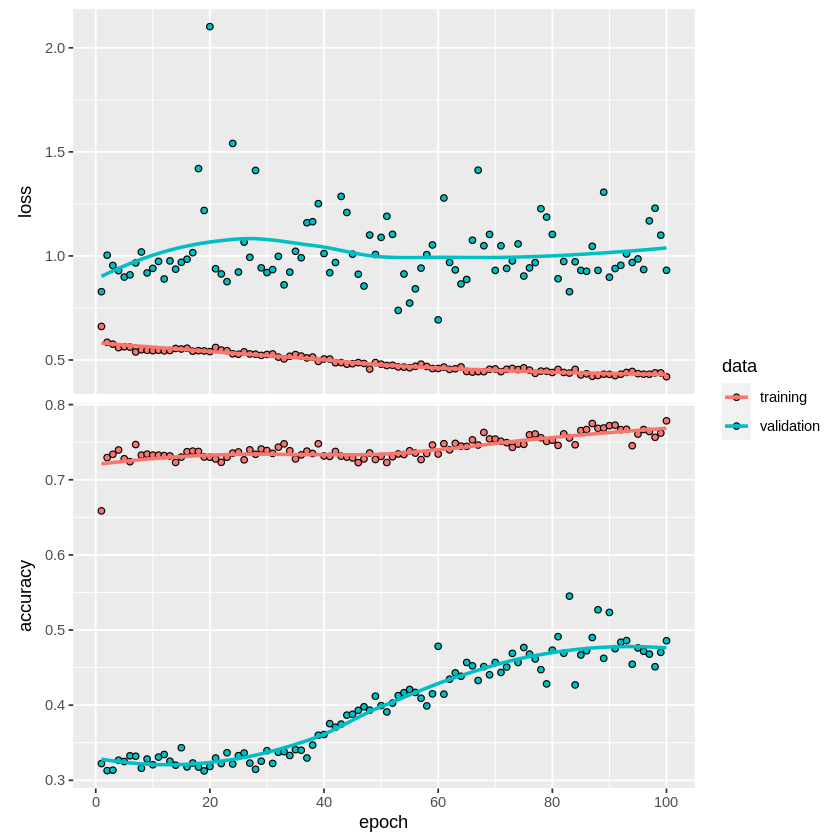

In [9]:
# 16 unit, 12000 lookback

model <- keras_model_sequential() %>% 
  layer_gru(units = 16, input_shape = list(NULL, 3) ,
              recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE) %>% 
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = "accuracy"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 50,
  epochs = 100,
  validation_data = val_gen,
  validation_steps = val_steps
)

model %>% evaluate(test_gen, steps=test_steps)

plot(history)

In [ ]:
# 32 / 16 layers, 12000 lookback

model <- keras_model_sequential() %>% 
  layer_gru(units = 32, input_shape = list(NULL, 3) ,
              recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE,
            return_sequences = TRUE ) %>%
  layer_gru(units = 16 ,
              recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE) %>% 
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = "accuracy"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 50,
  epochs = 100,
  validation_data = val_gen,
  validation_steps = val_steps
)

model %>% evaluate(test_gen, steps=test_steps)

plot(history)

## CNN RNN

In [ ]:
lookback <- 48000 # 1200 seconds
step <- 4 # 10 observations per second
delay <- 0
batch_size <- 128

train_gen <- generator(
  data = combined,
  lookback = lookback,
  delay = delay,
  min_index = 1,
  max_index = {which(combined$pid=="JR8022") %>% max()},
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

val_gen = generator(
  data = combined,
  lookback = lookback,
  delay = delay,
  min_index = {which(combined$pid=="JR8022") %>% max() + 1},
  max_index = {which(combined$pid=="MJ8002") %>% max()},
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

test_gen <- generator(
  data = combined,
  lookback = lookback,
  delay = delay,
  min_index = {which(combined$pid=="MJ8002") %>% max() + 1},
  max_index = nrow(combined),
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

# Unrealistic to look at the whole validation or test sets; look at 5120 / 10000
val_steps <- (5120) / batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps <- (10000) / batch_size

In [ ]:
model <- keras_model_sequential() %>% 
  layer_conv_1d(filters = 64, 
            kernel_size = 32,
            input_shape = list(NULL, 3),
            activation = "relu"
            ) %>% 
  layer_max_pooling_1d(pool_size = 3) %>%
  layer_conv_1d(filters = 32,
            kernel_size = 16,
            activation="relu"
            ) %>%
  layer_max_pooling_1d(pool_size = 3) %>%
    layer_conv_1d(filters = 32,
            kernel_size = 8,
            activation="relu"
            ) %>%
  layer_max_pooling_1d(pool_size = 3) %>%
  bidirectional(
    layer_gru(units = 16,
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE)
   ) %>%
  layer_dense(units = 1, activation="sigmoid")

summary(model)

model %>% compile(
  optimizer = optimizer_rmsprop(lr = 0.0005),
  loss = "binary_crossentropy",
  metrics = "acc"
)

system.time(history <- model %>% fit(
  train_gen,
  steps_per_epoch = 50,
  epochs = 100,
  validation_data = val_gen,
  validation_steps = val_steps
))

model %>% evaluate(test_gen, steps=test_steps)

plot(history)